In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'car-plate-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F686454%2F1203932%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240716%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240716T140132Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0e4f0322f5af07ecd51c8e3a14d1e3a513d459a7b7c40abf7cc734fef7b9ee69894203603fd095596a3f6f712c51fbe06fc2ca40dee2b6e5fc11c47a0cae97eca9d9d390aa6c861f8d0411643e897075930faa90c546da3d7d899b2055703cba095d286715c5338320056f13f526df2b5fcab69f28a1c9958b6861a3877c3247d743dfafc41f8ff6ebdfccf0dfb98ebffbb84d964bbc583825311d12ce3c27e2145366af801c614ccc515cb796a927312a6ba201c7996e46f3ec04ca1cee97dcfa7a9420b25a3b768082653018e65a77f86d2a6bf8e4ab09dd9c272a01cfa73e97a9ba098e4f1f701926e962940540244a0b768d0d2cb918c8417571c145b22f,number-plate-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2224491%2F3753395%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240716%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240716T140132Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8816ea71ce5c9664cb2317b42ed9aba497a6cd2abf1958f066a23ea42e29ad5c6c91f860bb1ca99e43146ee92c84ef01f480008d5782df102ea65a03eb487af9e9682f97d59058b9e3f0eb89a1112474d4f921b5fd86898fddcf8e4dba8d1aca262788b0305aed6c8142dba9a8c6455d58c8d0398fece685fa27a78babb25942d7626e9d464a94217dfbbd9e8e698f8483bbe7af813819480ee1e14670b301b20af293ddc549440043d414d04dcb3c5b7881f6cf684bc5326cf2bbed22c64c750ead46351260d3f1afa1205b5a3753c9ec013bac56e98c750c1a3f533a147bb3fcadd68c42349d453785d09de2c9337041c3a052fc032175541ee89a0ecb12cb,car-number-plate-video:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4031275%2F7107894%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240716%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240716T140132Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbc428108a18e1cb795683b937043c36ea16696972063facec4dd055fc2c25d0d3ac718d7750d8e0e96df4bd55399a147f8af2afc472ae4152476e6b40db91232ee93811832338233edcf7e2ccb2237cabf7ebaf5e96c3a3d33d2679e8df857d97c12d706f95140baefee22a4765d00560f25b499168cc6906fe3dd6023e27f0ec259cf42b6f3b26377d32395f644ac3cb4ec2bfc9e93ac045f1aefd142c96497a612eee24a6d09566f4403594831135d23afae818e2a9ea46eed69b6d3ff21c8417b539fb1931c0dde1fd67b9d1e668f7d0ff094b48a7b5b5dbba03fbe3f1ef02c2a7962d4558cc308c704a0de0cd413cd1b639954c0bedf8527d275d3a68102'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 212910636 bytes downloaded
Downloaded and uncompressed: car-plate-detection
[==================================================] 432553012 bytes downloaded
Downloaded and uncompressed: number-plate-detection
[==================================================] 457084620 bytes downloaded
Downloaded and uncompressed: car-number-plate-video
Data source import complete.


The steps of pipeline are:

1.   Detect vehicles from a input image.
2.   Crop the ROIs with BBOX of vehicles detections.
3.   Detect plates from croped vehicle images.
4.   Crop the ROIs with BBOX of plate detections.
5.   Extract the plate number with OCR from croped plate detections.





Summary

1 | Librarys and Packeges

2 | Configurations

3 | Utils

4 | Data

6 | YAML file

7 | Images

8 | Train Detection Model

9 | Results

10 | OCR

Librarys and Packages



In [2]:
!pip install --upgrade ultralytics -qq
!pip install GPUtil -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.7/802.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 50.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
!pip install easyocr
!pip install pytesseract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 26.5 MB/s eta 0:00:00


In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import re
import glob
import subprocess
import random
import yaml
import tqdm
import gc


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from IPython.display import Video
from PIL import Image
import cv2

import ultralytics
from ultralytics import YOLO

import easyocr

import xml.etree.ElementTree as xet
from bs4 import BeautifulSoup

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import pytesseract

print('ultralytics version: ',ultralytics.__version__)

ultralytics version:  8.2.58


In [5]:
class CFG:

    #paths
    out_folder = f'/kaggle/working'
    class_name = ['car_plate']
    video_test_path = 'https://docs.google.com/uc?export=download&confirm=&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-'

    weights = 'yolov8s.pt'
    exp_name = 'car_plate_detection'
    img_size = (240,400)
    vehicles_class = [2, 3, 5, 7]

    #Yolo train parameters
    epochs = 50
    batch_size = 16
    optimizer = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    lr = 1e-5
    lr_factor = 0.01 #lo*lr_f
    weight_decay = 5e-4
    dropout = 0.5
    patience = int(0.7*epochs)
    profile = False
    label_smoothing = 0.0

    #models Confidance
    vehicle_conf = 0.5
    plate_conf = 0.3
    ocr_conf = 0.1

    seed = 42



In [6]:

def get_bbox(file_path):
    '''
    This function takes a file path as input.
    It extracts information about the bounding box (coordinates) from the XML file, specifically the values for xmin, xmax, ymin, and ymax.
    Returns a tuple containing the extracted coordinates (xmin, xmax, ymin, ymax).
    '''
    info = xet.parse(file_path)
    root = info.getroot()
    member_object = root.find('object')

    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    return  xmin, xmax, ymin, ymax



def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.seed):
    '''
    It randomly selects num_images image files from the specified folder.
    It then plots the image with the bounding box using Matplotlib, arranging the images in a grid.
    '''
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]



    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        img = cv2.imread(os.path.join(folder_path, file_name))


        xmin, xmax, ymin, ymax = get_bbox(file_path=os.path.join('/kaggle/input/car-plate-detection/annotations',
                                                                 file_name.replace('.png','.xml')))



        start_point = (xmin, ymax)
        end_point = (xmax, ymin)

        img = cv2.rectangle(img, start_point, end_point, (255,0,0), 3)


        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

def parse_xml_tags(data):
    """Parse xml label file, return image file name, and its coordinates as a dictionary
    """
    tags = ['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
    Bs_data = BeautifulSoup(data, "xml")
    d = dict()

    for t in tags:
        text = Bs_data.find(t).text
        if all(c.isdigit() for c in text):
            d[t] = int(text)
        else:
            d[t] = text
    return d




def convert_xml_txt_yolo(file_path,w_image,h_image):
    '''
    This function converts XML label information to YOLO format.
    It reads an XML file specified by the file path, extracts bounding box coordinates, and converts them to YOLO format.
    Returns a string in YOLO format
    '''
    with open(file_path,  'r') as f:
        label = parse_xml_tags(f.read())


    xmin = int(label['xmin'])
    xmax = int(label['xmax'])
    ymin = int(label['ymin'])
    ymax = int(label['ymax'])


    x_center = float((xmin+((xmax-xmin)/2))/w_image)
    y_center = float((ymin+((ymax-ymin)/2))/h_image)

    width = float((xmax-xmin)/w_image)
    height = float((ymax-ymin)/h_image)

    str_out = f'0 {x_center} {y_center} {width} {height}'

    return str_out

def display_image(image, print_info = True, hide_axis = False, figsize = (15,15), title=None):
    '''
    This function displays an image using Matplotlib.
    It takes an image file path or a NumPy array as input.
    It can print information about the image (type and shape), hide axis, and set a title.
    '''
    fig = plt.figure(figsize = figsize)
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)

        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        if image.shape[-1] == 3:
            image = image[..., ::-1]  # BGR to RGB
            img = Image.fromarray(image)
            plt.imshow(img)
        else:
            img = np.copy(image)
            plt.imshow(img,cmap = 'gray')

    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')
    if title is not None:
        plt.title(title)

    plt.show()

def create_dir(path):
    '''
    This function creates a directory at the specified path if it doesn't exist.
    '''
    if not os.path.exists(path):
        os.mkdir(path)

def gpu_report():
    '''
    This function provides information about the available GPUs, their properties, and CUDA version.
    It also prints GPU usage.
    '''
    if torch.cuda.is_available():
        # Get the number of available GPUs
        num_gpus = torch.cuda.device_count()
        print(f"Number of available GPUs: {num_gpus}")

        if num_gpus > 1:
            train_device, test_device = 0,1

        else:
            train_device, test_device = 0,0




        # Get information about each GPU
        for i in range(num_gpus):
            gpu_properties = torch.cuda.get_device_properties(i)
            print(f"\nGPU {i}: {gpu_properties.name}")
            print(f"  Total Memory: {gpu_properties.total_memory / (1024**3):.2f} GB")
            print(f"  CUDA Version: {gpu_properties.major}.{gpu_properties.minor}")


    else:
        print("CUDA is not available. You can only use CPU.")
        train_device, test_device = 'cpu', 'cpu'


    print('\n')
    gpu_usage()

    return train_device, test_device


def extract_roi(image, bounding_box):
    """
    Crop the input image based on the provided bounding box coordinates.

    Args:
        image (numpy.ndarray): The input image.
        bounding_box (tuple): A tuple containing (x_min, y_min, x_max, y_max)
            coordinates of the bounding box.

    Returns:
        numpy.ndarray: The cropped image.
    """
    x_min, x_max, y_min, y_max = bounding_box
    cropped_image = image[y_min:y_max, x_min:x_max]
    return cropped_image


def free_gpu_cache() -> None:
    print("Initial GPU Usage")
    gpu_usage()


    torch.cuda.empty_cache()


    print("GPU Usage after emptying the cache")
    gpu_usage()


def extract_ocr(roi_img, reader):
    '''
    This function performs Optical Character Recognition (OCR) on a cropped image (roi_img) using the specified OCR reader.
    It returns the recognized text (plate number) and confidence level.
    '''
    ocr_result = reader.readtext(np.asarray(roi_img), allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    text_plate = ''
    if len(ocr_result) > 0:

        for item in ocr_result:
            text, conf = item[-2], item[-1]
            text = text if conf > CFG.ocr_conf else ''
            text_plate+=text
    else:
        text_plate, conf = 'unreco_plate', 0

    text_plate = text_plate.lower()

    #text_plate = isValidNumberPlate(text_plate)


    return text_plate,conf


def inference_inside_roi(df_coords, img, model, device ,display = False):
    '''
    This function performs object detection on the region of interest (ROI) inside a given image.
    It takes a DataFrame (df_coords) containing bounding box coordinates, the image, a detection model, and the device.
    It returns the original image and a DataFrame (df_plate) with information about the detected plates.
    '''
    bboxs = df_coords[['xmin','xmax','ymin','ymax']].values.astype(int)
    classes = df_coords['class'].values


    df_plate = pd.DataFrame()
    for i,bbox in enumerate(bboxs):

        vehicle_img = extract_roi(img, bbox)

        results = model.predict(vehicle_img,
                        conf = CFG.plate_conf,
                        classes =[0],
                        device = device,
                        verbose = False)

        position_frame = pd.DataFrame(results[0].cpu().numpy().boxes.data,
                                       columns = ['xmin', 'ymin', 'xmax',
                                                  'ymax', 'conf', 'class'])

        position_frame['class'] = position_frame['class'].replace({0:'car_plate'})
        position_frame['plate_number'] = 'unreco_plate'

        #Filter cases with more them one plate per vehicle
        position_frame = position_frame.loc[position_frame['conf'] == position_frame['conf'].max(),:]

        #adjust bbox of plate for complete image
        position_frame['xmin']+=bbox[0]
        position_frame['xmax']+=bbox[0]
        position_frame['ymin']+=bbox[2]
        position_frame['ymax']+=bbox[2]

        if display:
            display_image(vehicle_img, hide_axis = True, figsize =(10,10), title='Vehicle ROI Image')

        if len(position_frame) > 0:

            plate_bbox = position_frame[['xmin','xmax','ymin','ymax']].values.squeeze().astype(int)
            plate_img = extract_roi(img, plate_bbox)
            text_plate, conf_ocr = extract_ocr(plate_img, reader)
            position_frame['plate_number'] = text_plate

            if display:
                display_image(plate_img, hide_axis = True, figsize =(10,10), title=f'ROI Plate | Nº: {text_plate}')




        position_frame = position_frame[['xmin', 'ymin', 'xmax','ymax' ,'conf', 'class', 'plate_number']]


        df_plate = pd.concat([df_plate, position_frame], axis = 0)

    return img, df_plate

def drawBBox(df_coords, img, title = '' ,thickness=1):
    '''
    This function draws bounding boxes on the input image based on the coordinates in the DataFrame (df_coords).
    It also labels the detected objects with their classes and, if applicable, the plate numbers.
    '''
    cords = df_coords[['xmin','xmax','ymin','ymax']].values.astype(int)
    classes = df_coords['class'].values

    for i,detection in enumerate(cords):


        start_point = (detection[0], detection[-1]) # x_min, y_max
        end_point = (detection[1], detection[2]) # x_max, y_min
        class_detected = classes[i]


        if class_detected == 'car_plate':
            number_plate = df_coords['plate_number'].values[i]
            cv2.rectangle(img, start_point, end_point, (0,0,190), thickness)
            cv2.putText(img=img, text=f'{class_detected} ',
                org= (detection[0], detection[2]-20),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
            cv2.putText(img=img, text=f'{number_plate}',
                org= (detection[0]-10, detection[-1]+30),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
        else:
            cv2.rectangle(img, start_point, end_point, (255,0,0), thickness)

            cv2.putText(img=img, text=f'{class_detected}',
                org= (detection[0], detection[2]-20),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 255, 0),thickness=2)



    return img

def csv_pipe(input_df):
    '''
    This function takes a DataFrame as input, filters plate numbers with count > 3 (excluding 'unreco_plate'),
    removes duplicates, and outputs a new DataFrame with a 'plate number' column.
    '''
    #input_df = input_df.drop(columns=['Frame','Class','Plate Number','xmin','ymin','xmax','ymax','conf','class'])
    # Filter plate numbers with count > 3 (excluding 'unreco_plate')
    filtered_df = input_df[input_df['plate_number'] != 'unreco_plate']

    plate_counts = filtered_df['plate_number'].value_counts()
    selected_plate_numbers = plate_counts[plate_counts > 3].index

    # Create a new DataFrame with unique plate numbers
    output_df = pd.DataFrame({'plate number': selected_plate_numbers})

    return output_df


In [7]:
anoattions_path_xml = glob.glob('/kaggle/input/car-plate-detection/annotations/*.xml')
image_paths = glob.glob('/kaggle/input/car-plate-detection/images/*.png')

info = xet.parse(anoattions_path_xml[0])
xet.dump(info)

<annotation>
    <folder>images</folder>
    <filename>Cars380.png</filename>
    <size>
        <width>400</width>
        <height>225</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>316</xmin>
            <ymin>91</ymin>
            <xmax>364</xmax>
            <ymax>126</ymax>
        </bndbox>
    </object>
</annotation>


Splitting data into training and testing data

In [8]:
index = np.arange(len(anoattions_path_xml))
np.random.shuffle(index)

val_index = index[:50]
# test_index = index[50:100]
train_index = index[50:]
# val_index = np.random.choice(index, size=50, replace=False)

print('Train Size: ', len(train_index))
print('Valid Size: ', len(val_index))
# print('Test Size: ', len(test_index))

Train Size:  383
Valid Size:  50


In [9]:
#create paths for yolo labels
create_dir(CFG.out_folder)
datasets = ['train','valid']
folders = ['images','labels']
for datset in datasets:
    path_1 = CFG.out_folder + f'/{datset}'
    create_dir(path_1)
    for folder in folders:
        path_2 = CFG.out_folder + f'/{datset}/{folder}'

        create_dir(path_2)

        print(path_2)

/kaggle/working/train/images
/kaggle/working/train/labels
/kaggle/working/valid/images
/kaggle/working/valid/labels


In [10]:
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt


# Define val_index and train_index here (copied from ipython-input-0-f0c4635805c0)
index = np.arange(len(anoattions_path_xml))
np.random.shuffle(index)

val_index = index[:50]
# test_index = index[50:100]
train_index = index[50:]
# val_index = np.random.choice(index, size=50, replace=False)

print('Train Size: ', len(train_index))
print('Valid Size: ', len(val_index))
# print('Test Size: ', len(test_index))

for i, img_path in enumerate(image_paths):
    image = cv2.imread(img_path)

    resize_image = cv2.resize(image,CFG.img_size)
    h_image,w_image,_ = image.shape

    label_path = img_path.replace('images','annotations').replace('.png','.xml')


    label_text = convert_xml_txt_yolo(label_path,w_image,h_image)



    text_file_name = img_path.split('/')[-1].replace('.png','.txt')
    img_file_name = img_path.split('/')[-1]
#     print(img_file_name)


    if i in val_index:
        dataset = 'valid'
    elif i in train_index:
        dataset = 'train'
    elif i in test_index:
        dataset = 'test'


    text_path = f'{CFG.out_folder}/' + dataset +'/'+'/labels/' + text_file_name
    new_img_path = f'{CFG.out_folder}/' + dataset +'/images/'+ img_file_name

    shutil.copy2(img_path,new_img_path)
    cv2.imwrite(new_img_path, resize_image)


    text_file = open(text_path, "w")
    text_file.write(label_text)
    text_file.close()

Train Size:  383
Valid Size:  50


In [11]:
dict_file = {
    'train': os.path.join(CFG.out_folder, 'train'),
    'val': os.path.join(CFG.out_folder, 'valid'),
    'nc': len(CFG.class_name),
    'names': CFG.class_name
    }

with open(os.path.join('./', 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

with open('./data.yaml', 'r') as file:
    data_yaml = yaml.safe_load(file)

print(yaml.dump(data_yaml))

names:
- car_plate
nc: 1
train: /kaggle/working/train
val: /kaggle/working/valid



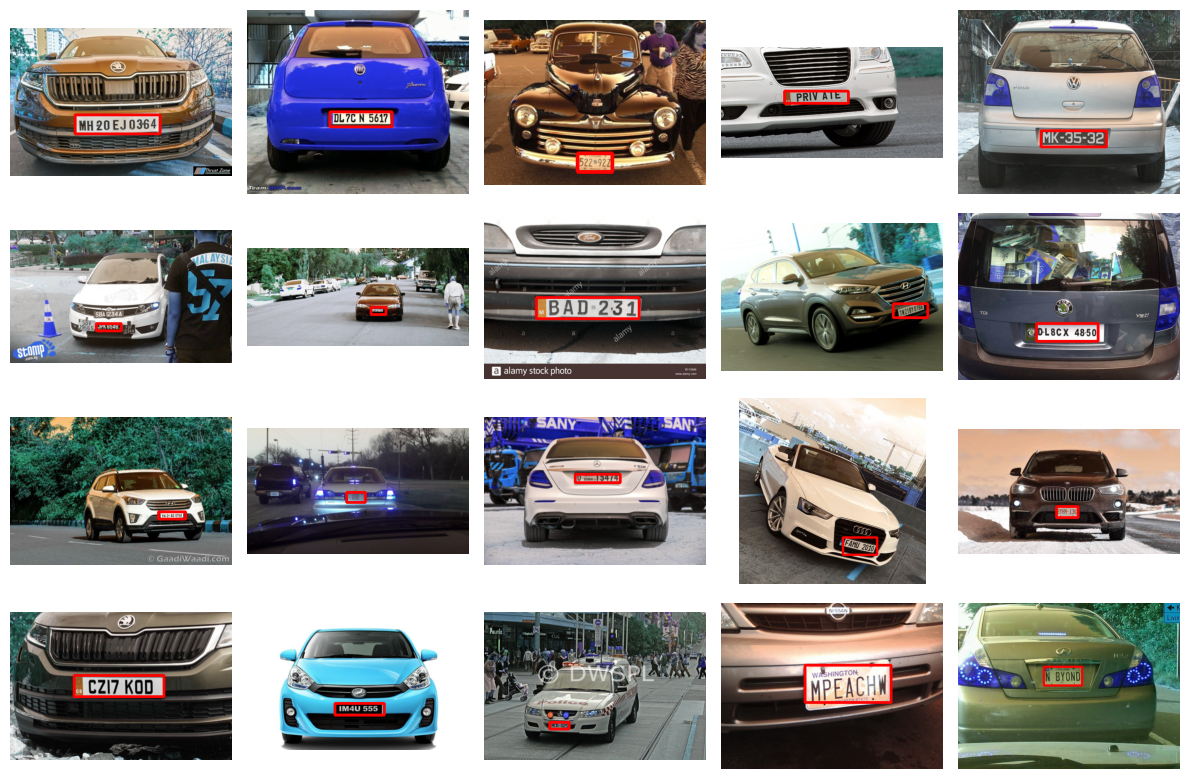

In [12]:
plot_random_images_from_folder(folder_path= '/kaggle/input/car-plate-detection/images',
                               num_images=20,
                               seed=CFG.seed)

In [13]:
! wandb disabled

/bin/bash: line 1: wandb: command not found


In [14]:
plate_model = YOLO(CFG.weights)

100%|██████████| 21.5M/21.5M [00:00<00:00, 213MB/s]


In [15]:
train_device, test_device = gpu_report()
plate_model.to(train_device)

print('\nModel Info')
print('Model: ', CFG.weights)
print('Device: ' ,plate_model.device)

Number of available GPUs: 1

GPU 0: Tesla T4
  Total Memory: 14.75 GB
  CUDA Version: 7.5


| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |

Model Info
Model:  yolov8s.pt
Device:  cuda:0


In [16]:
### train
plate_model.train(
    data = '/content/data.yaml', # Update the path to your data.yaml if it exists in the input directory

    task = 'detect',

    #imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.epochs,
    batch = CFG.batch_size,
    optimizer = CFG.optimizer,
    lr0 = CFG.lr,
    lrf = CFG.lr_factor,
    weight_decay = CFG.weight_decay,
    dropout = CFG.dropout,
    patience = CFG.patience,
    label_smoothing = CFG.label_smoothing,
    imgsz = 640,#CFG.img_size,

    name = CFG.exp_name,
    seed = CFG.seed,
    profile = False,

    val = True,
    amp = False,   #mixed precision
    exist_ok = False, #overwrite experiment
    resume = False,
    device = train_device,
    verbose = False,
    single_cls = False,
)

Ultralytics YOLOv8.2.58 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/data.yaml, epochs=50, time=None, patience=35, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=car_plate_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.5, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

100%|██████████| 755k/755k [00:00<00:00, 25.9MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

train: Scanning /kaggle/working/train/labels... 383 images, 0 backgrounds, 0 corrupt: 100%|██████████| 383/383 [00:00<00:00, 889.39it/s] 

train: New cache created: /kaggle/working/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/valid/labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 425.10it/s]

val: New cache created: /kaggle/working/valid/labels.cache


Plotting labels to runs/detect/car_plate_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=1e-05' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/car_plate_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      11.5G      1.431      5.867      1.296         22        640: 100%|██████████| 24/24 [00:16<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all         50         50      0.518       0.56      0.433      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      11.5G      1.416      1.803       1.28         25        640: 100%|██████████| 24/24 [00:14<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         50         50      0.655       0.66      0.601      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      11.5G      1.526      1.408      1.353         26        640: 100%|██████████| 24/24 [00:14<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         50         50    0.00804       0.54    0.00573      0.003



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      11.4G       1.53       1.38      1.336         36        640: 100%|██████████| 24/24 [00:14<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         50         50    0.00412       0.12    0.00223   0.000897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      11.4G      1.573      1.294      1.402         34        640: 100%|██████████| 24/24 [00:14<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         50         50     0.0641        0.5     0.0555     0.0265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      11.4G       1.53      1.234      1.388         26        640: 100%|██████████| 24/24 [00:14<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         50         50      0.137       0.06     0.0323     0.0109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      11.4G      1.525      1.112      1.377         28        640: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         50         50      0.282       0.48      0.207     0.0866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      11.4G      1.499      1.122      1.374         30        640: 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         50         50      0.588      0.657      0.613      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      11.4G      1.452     0.9999      1.357         28        640: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

                   all         50         50      0.857       0.48      0.547      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      11.4G      1.476      1.024      1.381         25        640: 100%|██████████| 24/24 [00:14<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         50         50      0.547      0.459      0.474      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      11.4G      1.361      0.951      1.312         28        640: 100%|██████████| 24/24 [00:14<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         50         50      0.732      0.708      0.725      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      11.4G      1.394     0.9434      1.316         28        640: 100%|██████████| 24/24 [00:14<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         50         50      0.868       0.64      0.771      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      11.4G      1.362      0.955      1.336         15        640: 100%|██████████| 24/24 [00:14<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         50         50      0.883      0.755      0.825      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      11.4G      1.365     0.9583      1.323         28        640: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         50         50      0.869      0.797        0.8      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      11.4G       1.35     0.9184      1.299         38        640: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.26it/s]

                   all         50         50      0.833      0.799      0.798      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      11.4G      1.319     0.8507      1.282         21        640: 100%|██████████| 24/24 [00:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         50         50      0.873      0.826      0.839      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      11.4G      1.314     0.8691       1.25         27        640: 100%|██████████| 24/24 [00:14<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         50         50       0.93      0.793      0.889      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      11.4G      1.316     0.8801      1.256         30        640: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]

                   all         50         50      0.792      0.839      0.849      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      11.4G      1.234     0.8172      1.222         28        640: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

                   all         50         50      0.957       0.76      0.807      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      11.4G      1.251     0.7933      1.231         29        640: 100%|██████████| 24/24 [00:15<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         50         50      0.906      0.767      0.844      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      11.4G      1.262     0.7862       1.23         29        640: 100%|██████████| 24/24 [00:15<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         50         50      0.886      0.776      0.856      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      11.4G      1.236     0.7751      1.211         31        640: 100%|██████████| 24/24 [00:14<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         50         50      0.902      0.736       0.84      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      11.4G       1.23     0.7399      1.214         35        640: 100%|██████████| 24/24 [00:14<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         50         50      0.951       0.82       0.89       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      11.4G      1.203     0.7496      1.186         36        640: 100%|██████████| 24/24 [00:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         50         50      0.906       0.77      0.863      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      11.4G      1.242     0.7927      1.233         31        640: 100%|██████████| 24/24 [00:14<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

                   all         50         50      0.889      0.802      0.864      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      11.4G      1.171     0.7117      1.174         32        640: 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

                   all         50         50      0.889        0.8      0.816      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      11.4G      1.197     0.7457      1.225         31        640: 100%|██████████| 24/24 [00:15<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

                   all         50         50      0.924       0.78      0.869      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      11.4G      1.187     0.7269      1.183         31        640: 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         50         50       0.93       0.84      0.904       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      11.4G      1.171     0.7173      1.183         24        640: 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         50         50      0.902       0.72      0.833      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      11.4G      1.153     0.7173      1.212         22        640: 100%|██████████| 24/24 [00:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         50         50      0.946       0.82      0.871      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      11.4G      1.171     0.6818      1.182         24        640: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         50         50      0.954      0.833      0.918      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      11.4G      1.112     0.6515       1.16         21        640: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         50         50      0.908      0.788      0.866      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      11.4G       1.12     0.6513      1.173         25        640: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         50         50      0.933      0.833        0.9      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      11.4G        1.1     0.6448      1.154         24        640: 100%|██████████| 24/24 [00:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         50         50      0.917       0.84      0.875      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      11.4G      1.094       0.63      1.148         36        640: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

                   all         50         50      0.874       0.84      0.861      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      11.4G      1.063     0.6191      1.144         26        640: 100%|██████████| 24/24 [00:15<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]

                   all         50         50      0.929        0.9      0.915      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      11.4G      1.043     0.6099      1.111         29        640: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

                   all         50         50      0.932      0.817      0.881      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      11.4G       1.06     0.6211      1.148         32        640: 100%|██████████| 24/24 [00:14<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         50         50      0.881       0.84      0.882      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      11.4G      1.077     0.5902      1.138         25        640: 100%|██████████| 24/24 [00:14<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         50         50      0.887       0.84       0.87      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      11.4G      1.053     0.5826      1.106         32        640: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         50         50      0.909      0.801      0.881      0.534


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      11.4G      1.055     0.5956      1.141         15        640: 100%|██████████| 24/24 [00:16<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         50         50      0.947       0.82      0.864      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      11.4G      1.018     0.5776      1.132         15        640: 100%|██████████| 24/24 [00:14<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         50         50      0.918       0.84      0.845      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      11.4G     0.9891     0.5553       1.12         14        640: 100%|██████████| 24/24 [00:14<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         50         50      0.933      0.838      0.855      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      11.4G     0.9904     0.5436      1.131         15        640: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

                   all         50         50      0.893      0.836      0.881      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      11.4G      0.959     0.5259      1.105         15        640: 100%|██████████| 24/24 [00:14<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

                   all         50         50      0.952      0.795      0.881      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      11.4G     0.9526     0.5055      1.099         15        640: 100%|██████████| 24/24 [00:15<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]

                   all         50         50      0.907        0.8      0.874      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      11.4G     0.9107     0.4982      1.088         15        640: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         50         50       0.89      0.807      0.887      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      11.4G     0.9494     0.5043       1.09         14        640: 100%|██████████| 24/24 [00:14<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         50         50      0.911      0.821      0.893      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      11.4G     0.9179     0.4907      1.086         15        640: 100%|██████████| 24/24 [00:14<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         50         50      0.954      0.829      0.898      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      11.4G     0.9347      0.491      1.106         15        640: 100%|██████████| 24/24 [00:14<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

                   all         50         50      0.914       0.85      0.899       0.53



50 epochs completed in 0.234 hours.
Optimizer stripped from runs/detect/car_plate_detection/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/car_plate_detection/weights/best.pt, 22.5MB

Validating runs/detect/car_plate_detection/weights/best.pt...
Ultralytics YOLOv8.2.58 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


                   all         50         50      0.929        0.9      0.915       0.53
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/detect/car_plate_detection


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a2712242fe0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

Save Model

In [ ]:
plate_model.export(
    format = 'openvino', # openvino, onnx, engine, tflite
    imgsz = 640,#CFG.img_size,
    half = False,#fp16
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.2.58 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from 'runs/detect/car_plate_detection4/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (21.5 MB)
requirements: Ultralytics requirement ['openvino>=2024.0.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.7/38.7 MB 46.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 7.0s, installed 1 package: ['openvino>=2024.0.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


OpenVINO: starting export with openvino 2024.2.0-15519-5c0f38f83f6-releases/2024/2...
OpenVINO: export success ✅ 10.6s, saved as 'runs/detect/car_plate_detection4/weights/best_openvino_model/' (42.8 MB)

Export complete (11.0s)
Results saved to /content/runs/detect/car_plate_detection4/weights
Predict:         yolo predict task=

'runs/detect/car_plate_detection4/weights/best_openvino_model'

Train Results

In [ ]:
import os

# Make sure the directory exists before trying to list its contents
res_path_base = CFG.out_folder + '/runs/detect/'
if os.path.exists(res_path_base):
    res_path = res_path_base + os.listdir(res_path_base)[-1]
    !tree {res_path}
else:
    print("Directory not found:", res_path_base)

Directory not found: /kaggle/working/runs/detect/


In [ ]:
plots_path = [f for f in os.listdir(res_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

batchs_plot = [f for f in plots_path if 'val_batch' in f]
curves_plot = [f for f in plots_path if 'curve' in f]

print('Examples BBOX ')
for path in batchs_plot:
    print(''.join(path.split('/')))
    display_image(os.path.join(res_path,path), hide_axis = True)


NameError: name 'res_path' is not defined

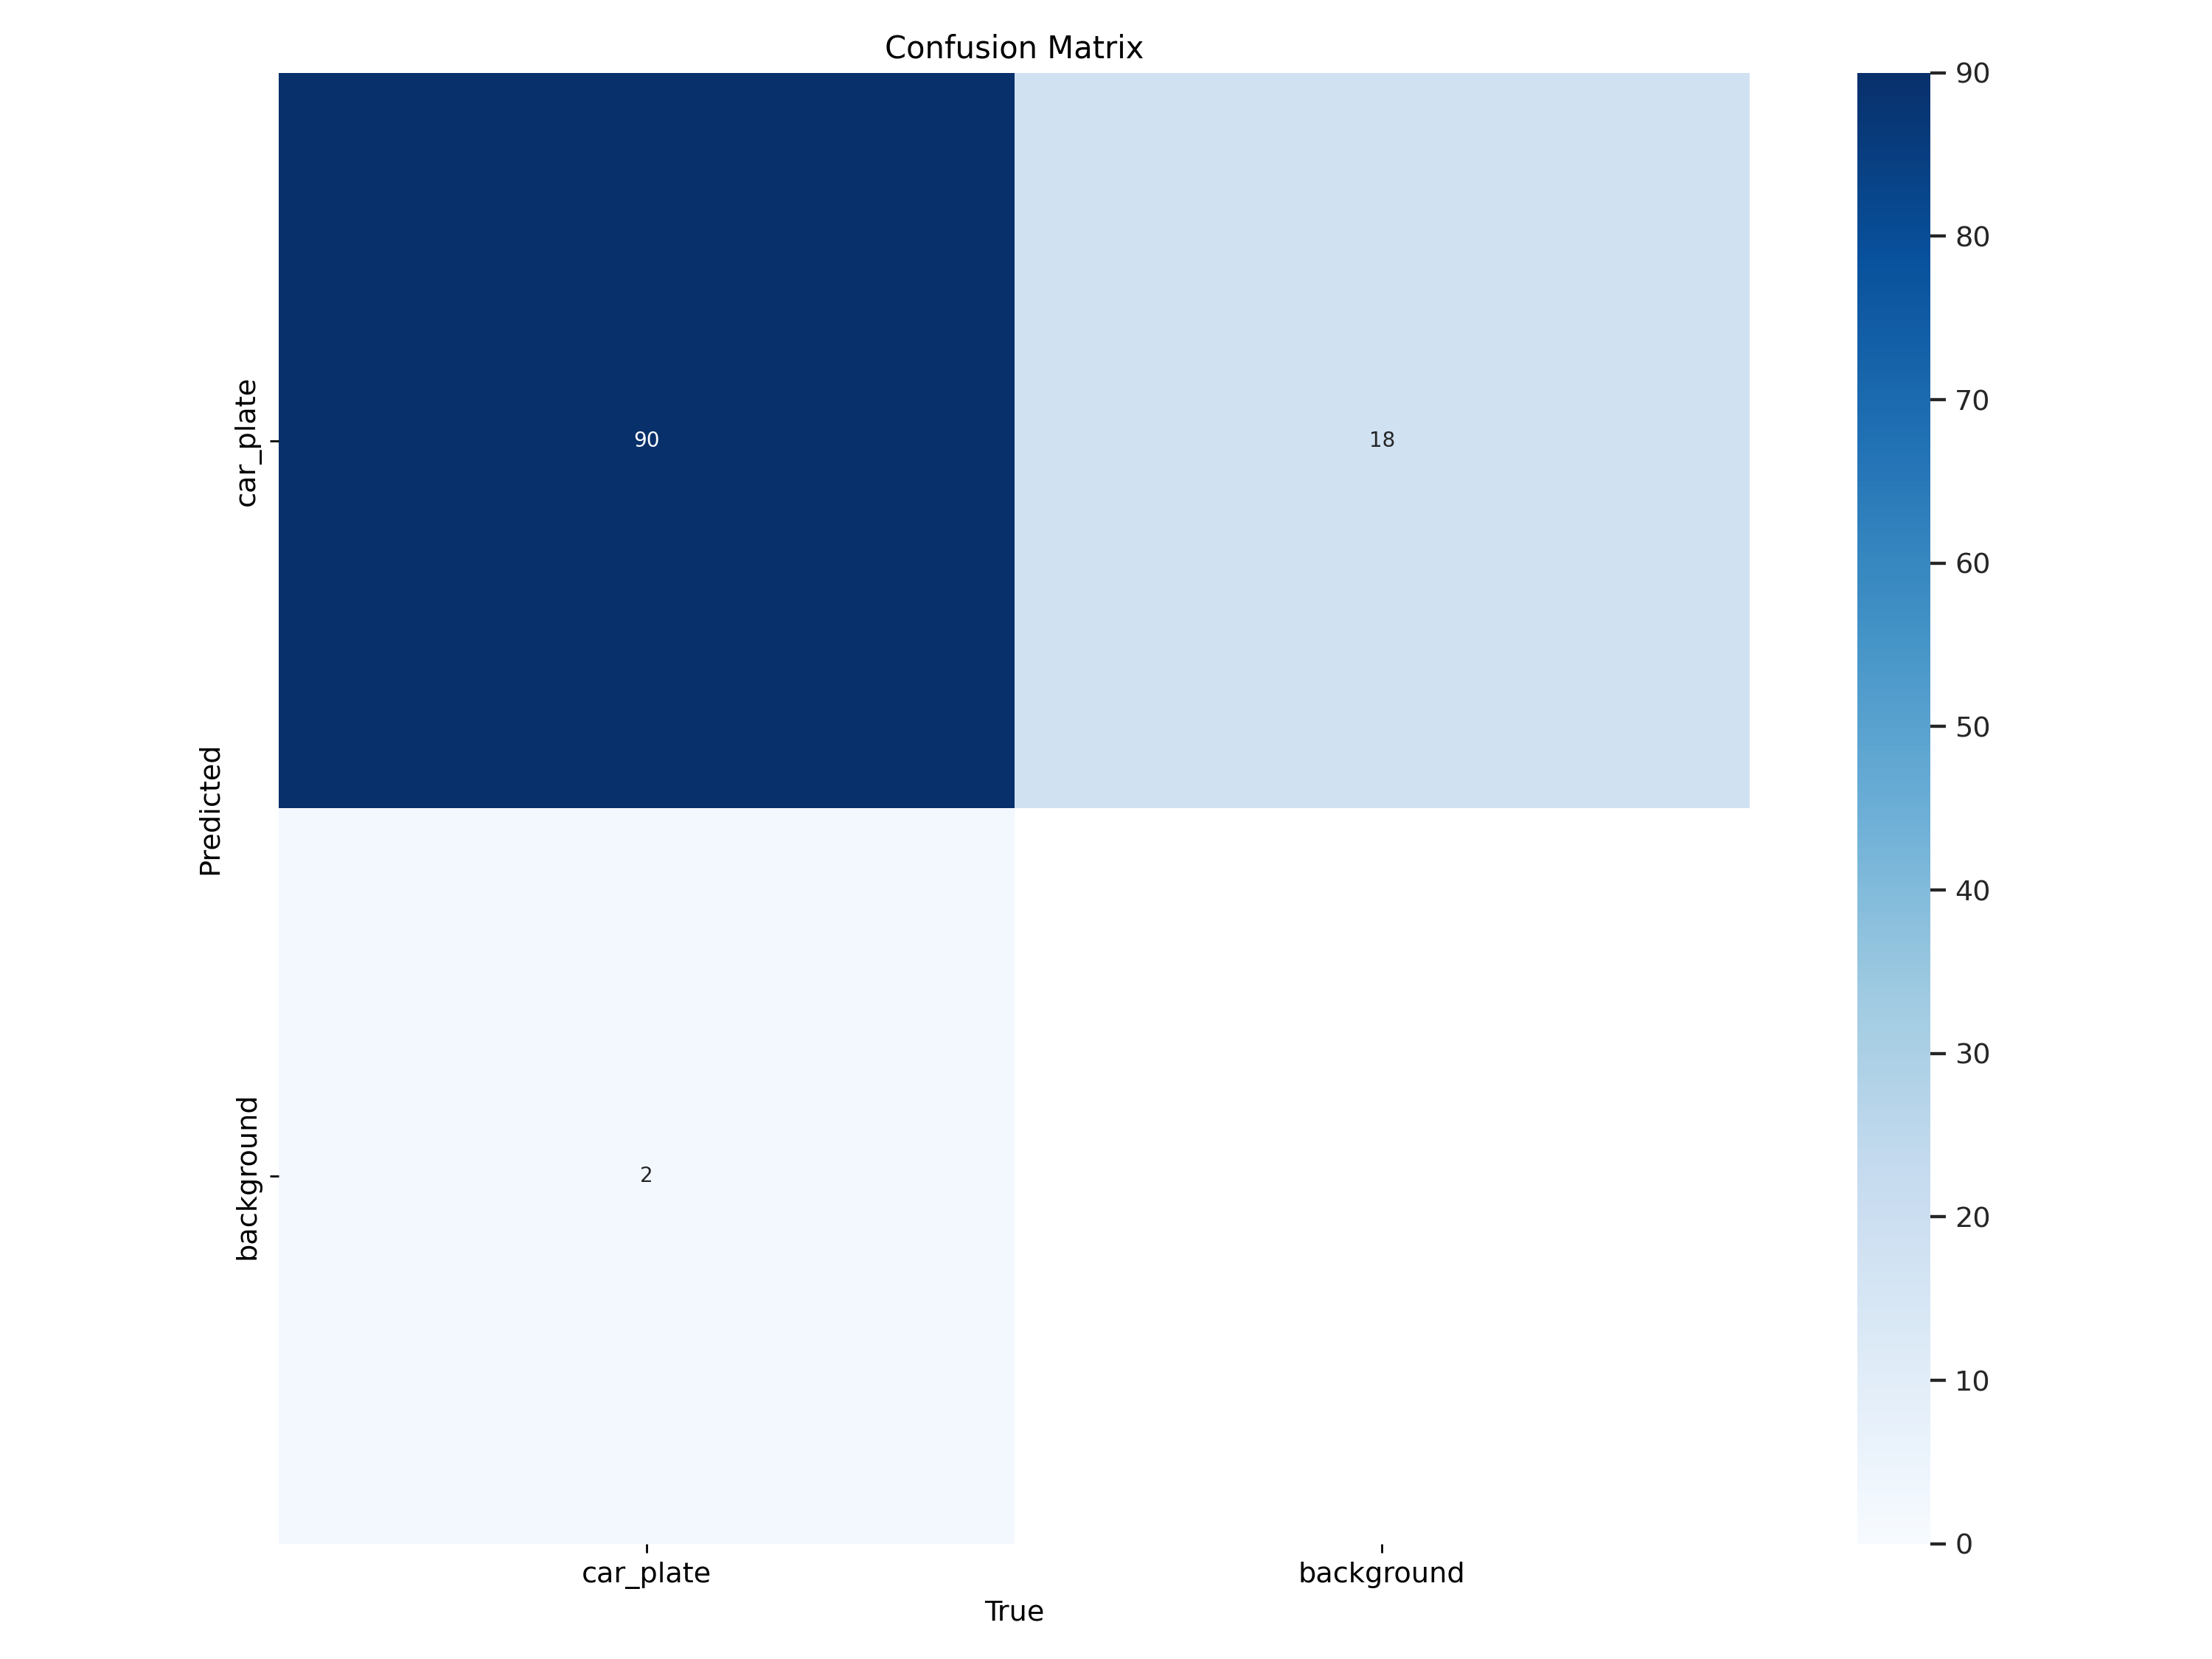

In [ ]:
from IPython.display import Image
Image("/content/runs/detect/car_plate_detection4/confusion_matrix.png")

In [ ]:
!export LC_ALL=en_US.UTF-8
!pip install Pillow
from PIL import Image
print('Curves Metrics')
for path in curves_plot:
    print(''.join(path.split('/')))
    display_image(os.path.join(res_path,path), hide_axis = True)

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
display_image(os.path.join(res_path,'results.png'))

In [ ]:
# plate_model = YOLO('/kaggle/input/best-model-car-plate-detection/best.pt')
vehicle_model = YOLO(CFG.weights)
reader = easyocr.Reader(['en'],  gpu=True if test_device != 'cpu' else False)

plate_model.to(test_device)
vehicle_model.to(test_device)

print('\nModels Info')
print('Plate Model: ', plate_model.device, 'Vehicle Model: ', plate_model.device)

In [ ]:
dict_all_classes = vehicle_model.model.names
dict_classes = {}
for id_class in CFG.vehicles_class:
    dict_classes[id_class] = dict_all_classes[id_class]

dict_classes

In [ ]:
test_images = glob.glob('/kaggle/input/number-plate-detection/images/*.jpeg')

In [ ]:
def run_pipeline(path, display=False):

    '''
    1. Detect vehicles from a input image.
    2. Crop the ROIs with BBOX of vehicles detections.
    3. Detect plates from croped vehicle images.
    4. Crop the ROIs with BBOX of plate detections.
    5. Extract the plate number with OCR from croped plate detections.
    '''

    image = cv2.imread(path)

    if display:
        display_image(image,
                      hide_axis =True,
                      figsize = (10,10),
                      title='Input Image')

    #1
    vehicle_results = vehicle_model.predict(image,
                            conf =CFG.vehicle_conf,
                            classes = CFG.vehicles_class,
                            device = test_device,
                            verbose = False,

                                 )

    df_vehicles = pd.DataFrame(vehicle_results[0].cpu().numpy().boxes.data,
                                   columns = ['xmin', 'ymin', 'xmax',
                                              'ymax','conf', 'class'])
    df_vehicles['class'] = df_vehicles['class'].replace(dict_classes)


    # 2, 3,4
    image, df_plates = inference_inside_roi(df_vehicles,
                                                image,
                                                plate_model,
                                                test_device,
                                                display = display)
    df_frame = pd.concat([df_vehicles, df_plates], axis = 0).reset_index(drop=True)
    #Draw results in output images
    image = drawBBox(df_frame, image, thickness=5)

    if display:
        display_image(image,
                      hide_axis =True,
                      figsize = (10,10),
                      title='Output Image')

    return df_frame, image

In [ ]:
df_frame, out_image  = run_pipeline(path = test_images[11], display=True)

In [ ]:
n_inferences = 15

num_cols = 3
num_rows = (n_inferences + num_cols - 1) // num_cols
fig,axes = plt.subplots(num_rows,num_cols, figsize=(num_cols*6, num_rows*7))



for i in range(n_inferences):
    df_frame, out_image  = run_pipeline(path = test_images[i], display=False)

    if num_rows == 1:
        ax = axes[i % num_cols]
    else:
        ax = axes[i // num_cols, i % num_cols]

    out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
    ax.imshow(out_image)

    ax.axis('off')
    ax.set_title(f'Output Image - {i}')

In [ ]:
def run_pipeline(frame, display=False):
    '''
    1. Detect vehicles from an input image.
    2. Crop the ROIs with BBOX of vehicles detections.
    3. Detect plates from cropped vehicle images.
    4. Crop the ROIs with BBOX of plate detections.
    5. Extract the plate number with OCR from cropped plate detections.
    '''

    if display:
        display_image(frame,
                      hide_axis=True,
                      figsize=(10, 10),
                      title='Input Image')

    # 1
    vehicle_results = vehicle_model.predict(frame,
                                            conf=CFG.vehicle_conf,
                                            classes=CFG.vehicles_class,
                                            device=test_device,
                                            verbose=False)

    df_vehicles = pd.DataFrame(vehicle_results[0].cpu().numpy().boxes.data,
                               columns=['xmin', 'ymin', 'xmax',
                                        'ymax', 'conf', 'class'])
    df_vehicles['class'] = df_vehicles['class'].replace(dict_classes)

    # 2, 3,4
    _, df_plates = inference_inside_roi(df_vehicles,
                                        frame,
                                        plate_model,
                                        test_device,
                                        display=display)
    df_frame = pd.concat([df_vehicles, df_plates], axis=0).reset_index(drop=True)


    # Draw results in output images
    frame = drawBBox(df_frame, frame, thickness=5)

    if display:
        display_image(frame,
                      hide_axis=True,
                      figsize=(10, 10),
                      title='Output Image')

    return df_frame, frame


In [ ]:
import cv2
import pandas as pd

def process_video(input_video_path, output_video_path, output_csv_path):
    # Open the input video file
    cap = cv2.VideoCapture(input_video_path)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Create VideoWriter for output video
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out_video = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Create DataFrame to store results
    columns = ['Frame', 'Class', 'Plate Number', 'xmin', 'ymin', 'xmax', 'ymax']
    results_df = pd.DataFrame(columns=columns)

    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Run the pipeline on the current frame
        df_frame, output_image = run_pipeline(frame, display=False)

        # Append the results to the DataFrame
        df_frame['Frame'] = frame_count
        results_df = pd.concat([results_df, df_frame], ignore_index=True)

        # Write the processed frame to the output video
        out_video.write(output_image)

        frame_count += 1

    # Release the video capture and writer objects
    cap.release()
    out_video.release()

    # Save the results DataFrame to CSV
    results_df = csv_pipe(results_df)
    results_df.to_csv(output_csv_path, index=False)

if __name__ == "__main__":
    input_video_path = '/kaggle/input/car-number-plate-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition.mp4'
    output_video_path = '/kaggle/working/video_output.avi'
    output_csv_path = '/kaggle/working/results.csv'


In [ ]:

process_video('/kaggle/input/car-number-plate-video/Traffic Control CCTV.mp4', '/kaggle/working/Video1.avi', '/kaggle/working//Video1.csv')
process_video('/kaggle/input/car-number-plate-video/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition (1).mp4', '/kaggle/working/Video2.avi', '/kaggle/working//Video2.csv')


In [ ]:

!ffmpeg -i /kaggle/working/Video1.avi -c:v libx264 -crf 23 -c:a aac -q:a 100 -y /kaggle/working/Video1.mp4
!ffmpeg -i /kaggle/working/Video2.avi -c:v libx264 -crf 23 -c:a aac -q:a 100 -y /kaggle/working/Video2.mp4

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

play('/kaggle/working/Video1.mp4')

In [ ]:
play('/kaggle/working/Video2.mp4')